<a href="https://colab.research.google.com/github/emmelinetsen/deep_learning/blob/master/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autodiff Python Library for MNST Classifier

1. Do write autodiff python  library (we discussed in class)  and based on it , do  mnist classifier in colab (similar to last exercise but using autodiff library  that you will write instead of direct numpy)


https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

In [0]:
import numpy as np

class Tensor (object):
    
    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        if(id is None):
            self.id = np.random.randint(0,100000)
        else:
            self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if(creators is not None):
            for c in creators:
                if(self.id not in c.children):
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True 
        
    def backward(self,grad=None, grad_origin=None):
        if(self.autograd):
 
            if(grad is None):
                grad = Tensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0):
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad
            
            # grads must not have grads of their own
            assert grad.autograd == False
            
            # only continue backpropping if there's something to
            # backprop into and if all gradients (from children)
            # are accounted for override waiting for children if
            # "backprop" was called on this variable directly
            if(self.creators is not None and 
               (self.all_children_grads_accounted_for() or 
                grad_origin is None)):

                if(self.creation_op == "add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if(self.creation_op == "sub"):
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if(self.creation_op == "mul"):
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)                    
                    
                if(self.creation_op == "mm"):
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if(self.creation_op == "transpose"):
                    self.creators[0].backward(self.grad.transpose())

                if("sum" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim,
                                                               self.creators[0].data.shape[dim]))

                if("expand" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if(self.creation_op == "neg"):
                    self.creators[0].backward(self.grad.__neg__())
                    
                if(self.creation_op == "sigmoid"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (self * (ones - self)))

                if(self.creation_op == "relu"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))
                
                if(self.creation_op == "tanh"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))

                if(self.creation_op == "cross_entropy"):
                    # print("Softmax Output", self.softmax_output)
                    # print("Target", self.target_dist)
                    dx = self.softmax_output - self.target_dist
                    self.creators[0].backward(Tensor(dx))
                
                if(self.creation_op == "index_select"):
                    new_grad = np.zeros_like(self.creators[0].data)
                    indices_ = self.index_select_indices.data.flatten()
                    grad_ = grad.data.reshape(len(indices_), -1)
                    for i in range(len(indices_)):
                        new_grad[indices_[i]] += grad_[i]
                    self.creators[0].backward(Tensor(new_grad))

                    
    def __add__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if(self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data - other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data * other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if(self.autograd):
            return Tensor(self.data.sum(dim),
                          autograd=True,
                          creators=[self],
                          creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    def expand(self, dim,copies):

        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if(self.autograd):
            return Tensor(new_data,
                          autograd=True,
                          creators=[self],
                          creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if(self.autograd):
            return Tensor(self.data.transpose(),
                          autograd=True,
                          creators=[self],
                          creation_op="transpose")
        
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if(self.autograd):
            return Tensor(self.data.dot(x.data),
                          autograd=True,
                          creators=[self,x],
                          creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def sigmoid(self):
        if(self.autograd):
            return Tensor(1 / (1 + np.exp(-self.data)),
                          autograd=True,
                          creators=[self],
                          creation_op="sigmoid")
        return Tensor(1 / (1 + np.exp(-self.data)))

    def tanh(self):
        if(self.autograd):
            return Tensor(np.tanh(self.data),
                          autograd=True,
                          creators=[self],
                          creation_op="tanh")
        return Tensor(np.tanh(self.data))

    def relu(self):
        if(self.autograd):
            return Tensor(((self.data > 0) * self.data),
                          autograd=True,
                          creators=[self],
                          creation_op="relu")
        return Tensor(np.tanh(self.data))
    
    def index_select(self, indices):

        if(self.autograd):
            new = Tensor(self.data[indices.data],
                         autograd=True,
                         creators=[self],
                         creation_op="index_select")
            new.index_select_indices = indices
            return new
        return Tensor(self.data[indices.data])
    
    def cross_entropy(self, target_indices):

        temp = np.exp(self.data)
        softmax_output = temp / np.sum(temp,
                                       axis=len(self.data.shape)-1,
                                       keepdims=True)
        
        t = target_indices.data.flatten()
        p = softmax_output.reshape(len(t),-1)
        # print("P:", p)
        # print("T:", t)
        target_dist = np.eye(p.shape[1])[t]
        loss = -(np.log(p) * (target_dist)).sum(1).mean()
    
        if(self.autograd):
            out = Tensor(loss,
                         autograd=True,
                         creators=[self],
                         creation_op="cross_entropy")
            out.softmax_output = softmax_output
            out.target_dist = target_dist
            return out

        return Tensor(loss)
        
    
    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):
        return str(self.data.__str__())  

# Adding Layers
class Layer(object):
    
    def __init__(self):
        self.parameters = list()
        
    def get_parameters(self):
        return self.parameters


class Tanh(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.tanh()
    
class Sigmoid(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.sigmoid()

# Adding Optimization
class SGD(object):
    
    def __init__(self, parameters, alpha=0.1):
        self.parameters = parameters
        self.alpha = alpha
    
    def zero(self):
        for p in self.parameters:
            p.grad.data *= 0
        
    def step(self, zero=True):
        
        for p in self.parameters:
            
            p.data -= p.grad.data * self.alpha
            
            if(zero):
                p.grad.data *= 0

# Linear Layer
class Linear(Layer):

    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        W = np.random.randn(n_inputs, n_outputs) * np.sqrt(2.0/(n_inputs))
        self.weight = Tensor(W, autograd=True)
        self.bias = Tensor(np.zeros(n_outputs), autograd=True)
        
        self.parameters.append(self.weight)
        self.parameters.append(self.bias)

    def forward(self, input):
        return input.mm(self.weight)+self.bias.expand(0,len(input.data))

# Sequential Layer
class Sequential(Layer):
    
    def __init__(self, layers=list()):
        super().__init__()
        
        self.layers = layers
    
    def add(self, layer):
        self.layers.append(layer)
        
    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input
    
    def get_parameters(self):
        params = list()
        for l in self.layers:
            params += l.get_parameters()
        return params
  
# MSE Loss
class MSELoss(Layer):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, pred, target):
        return ((pred - target)*(pred - target)).sum(0)


class Relu(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.relu()
    

class Softmax(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.softmax()

class CrossEntropyLoss(object):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, input, target):
        return input.cross_entropy(target)

In [7]:
p = np.array([[0,1,2,3], [4,5,6,7]])
t = 0
np.eye(p.shape[1])[t]

array([1., 0., 0., 0.])

In [8]:
p.shape[1]

4

In [0]:
import numpy as np
from tensorflow.keras.datasets import mnist

np.random.seed(1)

# loading the mnist data into training and testing data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# getting the first 1000 data and reshaping the dataset for the first 1000
# scaling the input to 255
img, labels = (x_train[0:1000].reshape(1000,28*28) / 255), y_train[0:1000]

# creating an array of zeros 
one_hot_labels = np.zeros((len(labels), 10))


# assigning 1 to where the label would be for that particular array
# for example, if the array 
for i,l in enumerate(labels):
  one_hot_labels[i][l] = 1
labels = one_hot_labels

import sys, numpy as np

test_img = x_test.reshape(len(x_test), 28*28) / 255
test_label = np.zeros((len(y_test), 10))

for i,l in enumerate(y_test):
    test_label[i][l] = 1

In [13]:
# x_train[0]


np.random.seed(0)

data = Tensor(np.array(x_train[0]), autograd=True)
t = y_train[0]
target = Tensor(np.array([t]*28), autograd=True)
# t = labels[0]
# target = Tensor(t*10, autograd=True)
         
model = Sequential([Linear(28,28), Relu(), 
                    Linear(28,15), Relu(),
                    Linear(15,10)])

criterion = CrossEntropyLoss()

optim = SGD(parameters=model.get_parameters(), alpha=0.1)

for i in range(1):
    
    # Predict
    pred = model.forward(data)

    # Compare
    loss = criterion.forward(pred, target)
  
    # Learn
    loss.backward(Tensor(np.ones_like(loss.data)))
    optim.step()
    # print(loss)

print(pred)
# print(y_train[0])

[[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [ -48.28660289  -11.46317745  -59.09231186 -118.1390371    48.27313553
    68.22849653  -33.67332355  -63.30599138   11.70656736   20.52135836]
 [-101.00513955   59.12995848  -82.39388287 -193.20274748  136.46572602
    93.63813327  -38.90186824 -129.51993855  -45.10246337   33.08826985]
 [  58.9716159    93.1963

In [14]:
class Embedding(Layer):
    
    def __init__(self, vocab_size, dim):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.dim = dim
        
        # this random initialiation style is just a convention from word2vec
        self.weight = Tensor((np.random.rand(vocab_size, dim) - 0.5) / dim, autograd=True)
        
        self.parameters.append(self.weight)
    
    def forward(self, input):
        return self.weight.index_select(input)

import numpy
np.random.seed(0)

# data indices
data = Tensor(np.array([1,2,1,2]), autograd=True)

# target indices
target = Tensor(np.array([0,1,0,1]), autograd=True)

model = Sequential([Embedding(3,3), Tanh(), Linear(3,4)])
criterion = CrossEntropyLoss()

optim = SGD(parameters=model.get_parameters(), alpha=0.1)

for i in range(10):
    
    # Predict
    pred = model.forward(data)
    
    # Compare
    loss = criterion.forward(pred, target)
    
    # Learn
    loss.backward(Tensor(np.ones_like(loss.data)))
    optim.step()
    print(loss)

1.3885032434928422
0.9558181509266036
0.6823083585795604
0.509525996749312
0.39574491472895856
0.31752527285348275
0.2617222861964216
0.22061283923954234
0.18946427334830074
0.16527389263866668


# Keras Models

2.Do Keras models for four problems (4 different data sets)

a) boolean cross entropy

b) sparse categorical crossentropy (softmax)

c) logistic regression

d) multi head classification (multi class classification)

Write proper colabs (points based on how cleanly and well documented your colabs are. checkout the tensorflow.org tutorial colabs as a template (i shared in announcement). Proper integration with tensorboard and metrics visualization. Proper visualize the input samples, results, losses, confusion matrices etc.. (just like fastai kind of colabs).

## Boolean Cross Entropy

In [19]:
from google.colab import drive
drive.mount('/content/drive/')
!unzip -uq '/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/dog-breed-id/train.zip'

Mounted at /content/drive/


In [0]:
# dogs and cats
# https://www.tensorflow.org/tutorials/images/classification

## Sparse Categorical Crossentropy

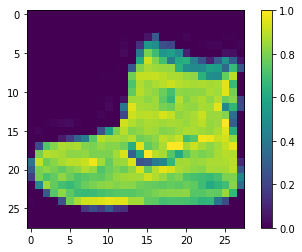

In [24]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# using fashion mnist dataset
fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# scaling the data
x_train = x_train / 255.0
x_test = x_test / 255.0

# class names from fashion mnist
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

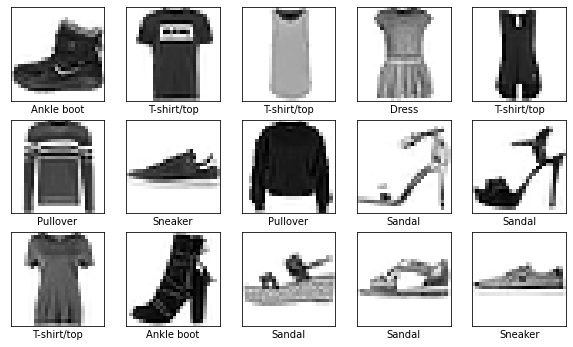

In [29]:
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [0]:
# build model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.fit(train_images, train_labels, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4993 - accuracy: 0.8243
Epoch 2/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3732 - accuracy: 0.8648
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3367 - accuracy: 0.8779
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3137 - accuracy: 0.8840
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2940 - accuracy: 0.8910
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2774 - accuracy: 0.8971
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2650 - accuracy: 0.9010
Epoch 8/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2543 - accuracy: 0.9061
Epoch 9/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2450 - accuracy: 0.9087
Epoch 10/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.238

In [51]:
# evaluate accuracy
loss, acc = model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.3550 - accuracy: 0.8904


In [0]:
# Add softmax layer to convert logits to probabilities
model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [64]:
# Make predictions using the model
pred = model.predict(x_test)
pred[0]

array([4.01807787e-09, 1.74910255e-08, 1.04350348e-11, 4.26760271e-14,
       6.28592610e-13, 5.37475785e-07, 1.04082444e-10, 7.23778852e-04,
       1.00115782e-09, 9.99275625e-01], dtype=float32)

In [65]:
np.argmax(pred[10])

4

In [66]:
y_test[10]

4

In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

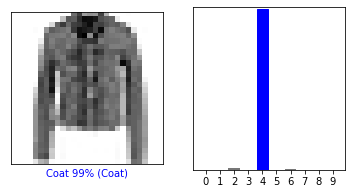

In [68]:
i = 10
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, pred[i], y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, pred[i],  y_test)
plt.show()

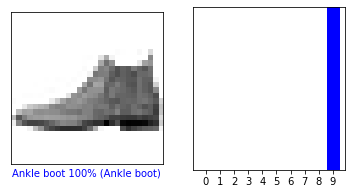

In [69]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, pred[i], y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, pred[i],  y_test)
plt.show()

## Logistic Regression

# New Section

Pick problems from either kaggle or from paperwithcode.com for this exercise.

Try to use as many advanced  features of keras as possible 

Ensure you do dropout, early stopping and l2 regularization techniques 
Ensure you use proper network initialization and optimizer (see keras api) and proper activation functions in each layer.

Ensure you use proper number of neurons and proper layers 

Use mini batching and write your custom callbacks for printing custom metrics

Explore and use both functional api and sequential api.

 

Use https://github.com/keras-team/keras-tuner (Links to an external site.) for hyperparam tuning

 

Submit each of the model colab seperately (also onrender example web app link) in single directory (directory name is assignment 2).

 

Also checkin github the modelcards showcasing your work for each model - only evaluation section is mandatory - fairness stuff is not. 

 

https://modelcards.withgoogle.com/about (Links to an external site.)

 

https://research.google/pubs/pub48120/ (Links to an external site.)

https://arxiv.org/pdf/1810.03993.pdf (Links to an external site.)

https://medium.com/the-false-positive/increasing-transparency-in-machine-learning-models-311ee08ca58a (Links to an external site.)

 

Use nbdev for notebook development in structured way. seperate model/code files and tests using tools of nbdev.

https://www.youtube.com/watch?v=Hrs7iEYmRmg (Links to an external site.)


 

Ensure you give full proper access to your github - and submit top level url of the directory.

 

Follow keras coding conventions listed here : https://keras.io/contributing/ (Links to an external site.)

 

use PEP8 syntax conventions, but we aren't dogmatic when it comes to line length. Make sure your lines stay reasonably sized, though. To make your life easier, we recommend running a PEP8 linter:

Install PEP8 packages: pip install pep8 pytest-pep8 autopep8
Run a standalone PEP8 check: py.test --pep8 -m pep8
You can automatically fix some PEP8 error by running: autopep8 -i --select <errors> <FILENAME> for example: autopep8 -i --select E128 tests/keras/backend/test_backends.py
When committing, use appropriate, descriptive commit messages.

Update the documentation. If introducing new functionality, make sure you include code snippets demonstrating the usage of your new feature.

Submit your PR. If your changes have been approved in a previous discussion, and if you have complete (and passing) unit tests as well as proper docstrings/documentation, your PR is likely to be merged promptly.

 